In [4]:
# system tools
import warnings
import json
import sys
import string
import ast

# data cleaning + analysis tools
import pandas as pd
import datetime as dt
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

#nltk tools
import lda #Latent Dirichlet Allocation (create topics)
import gensim
from gensim import corpora, models #for constructing document term matrix
#from stop_words import get_stop_words
from gensim.models import Phrases
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

#set notebook preferences
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


### Import JSON file with city metadata - including which cities have sufficient Public Record Request (PRR) data for analysis

In [12]:
json_file = '../data/cities.json'

with open(json_file, 'r') as f:
    md = json.load(f)

###  Create dataframe of PRR data for all relevant cities

In [87]:
data_raw = pd.DataFrame(columns = ['city', 'month_year', 'Summary'])
city_list = []
for key, value in md.items():
    city = value['name']
    filepath = '/Users/alenastern/Google Drive File Stream/My Drive/Alena_Project/PR_Data/{}.csv'.format(city)
    if value["desc"] == "Y":
        try:
            df = pd.read_csv(filepath)
        except:
            try:
                df = pd.read_csv(filepath, encoding='mac_roman')
            except:
                continue
        print(key)
        name = key.split(' ')
        city_list.extend([x.lower() for x in name[:-1]])
    else:
        continue
    
    try:
        df['Create Date'] = pd.to_datetime(df['Create Date'])
    except:
        df['New'] = pd.to_datetime(df['Create Date'].apply(lambda x: re.findall('^\S*', x)[0]))
        df.drop(columns=['Create Date'], inplace = True)
        df.rename(index=str, columns={"New": "Create Date"}, inplace = True)

    df['month_year'] = df['Create Date'].dt.to_period('M')
    
    mc = df[['month_year', 'Summary']]
    mc['city'] = city
    
    data_raw = pd.concat([data_raw, mc])
    
print(city_list)

Arlington city
Asheville city
Bainbridge Island city
Boulder County
Cathedral City city
Clearwater city
Dayton city
Denton city
Everett city
Fort Collins city
Greensboro city
Hayward city
Kirkland city
Las Cruces city
Lynnwood city
Mercer Island city
Miami city
Middleborough town
New Orleans city
Oakland city
Oklahoma City city
Olympia city
Palo Alto city
Peoria city
Pullman city
Rancho Cucamonga city
Redmond city
Renton city
Sacramento city
San Francisco city
Tukwila city
Vallejo city
West Sacramento city
Winchester city
['arlington', 'asheville', 'bainbridge', 'island', 'boulder', 'cathedral', 'city', 'clearwater', 'dayton', 'denton', 'everett', 'fort', 'collins', 'greensboro', 'hayward', 'kirkland', 'las', 'cruces', 'lynnwood', 'mercer', 'island', 'miami', 'middleborough', 'new', 'orleans', 'oakland', 'oklahoma', 'city', 'olympia', 'palo', 'alto', 'peoria', 'pullman', 'rancho', 'cucamonga', 'redmond', 'renton', 'sacramento', 'san', 'francisco', 'tukwila', 'vallejo', 'west', 'sacrame

#### We can see the raw data below. Our raw dataset includes 86,416 PRRs from 33 different cities

In [88]:
data_raw.to_csv('data_raw.csv')

In [126]:
data_raw = pd.read_csv('data_raw.csv')

In [89]:
data_raw.head()

,Summary,city,month_year
0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06
1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06
2,"Copies of Building Permits of $5,000 valuation and up ($20,000 min for Re-Roofs), ($50,000 min. for Cell Tower upgrades), (Electrical, Mechanical & Plumbing at $100,000 min.) and (Solar Panels, Swimming Pools & Foundations at any valuation)",Arlington,2018-06
3,"police report filed to an officer against Wayne Parris (DOB 08-03-1957) from Brittany J. Parris. The paperwork I have has a case number D18-39 it is also stamped at the bottom with 18-1294, Iím not sure which number you will need. If there is any other information needed please let me know.",Arlington,2018-06
4,"Email Communications between Stephanie Shook, Dave Kraski, Bruce Stedman and Chad Schmidt in regards to Fire Protection District 21 billing and passage of contract for ALS Services. \n\nAlso any copies of Agenda Bills, D21 Contract and materials presented for review in Nov/Dec time frame in regards to the contract.",Arlington,2018-06


In [90]:
data_raw.shape

(110138, 3)

In [91]:
len(data_raw.city.unique())

34

In [92]:
data_raw.index = pd.RangeIndex(len(data_raw.index))

In [93]:
data_raw.reset_index(inplace=True)

### Create dataframe for cleaning by removing null summaries

In [94]:
data = data_raw.dropna(subset=['Summary'])

In [22]:
data.head()

,index,Summary,city,month_year
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06
2,2,"Copies of Building Permits of $5,000 valuation and up ($20,000 min for Re-Roofs), ($50,000 min. for Cell Tower upgrades), (Electrical, Mechanical & Plumbing at $100,000 min.) and (Solar Panels, Swimming Pools & Foundations at any valuation)",Arlington,2018-06
3,3,"police report filed to an officer against Wayne Parris (DOB 08-03-1957) from Brittany J. Parris. The paperwork I have has a case number D18-39 it is also stamped at the bottom with 18-1294, Iím not sure which number you will need. If there is any other information needed please let me know.",Arlington,2018-06
4,4,"Email Communications between Stephanie Shook, Dave Kraski, Bruce Stedman and Chad Schmidt in regards to Fire Protection District 21 billing and passage of contract for ALS Services. \n\nAlso any copies of Agenda Bills, D21 Contract and materials presented for review in Nov/Dec time frame in regards to the contract.",Arlington,2018-06


#### Function to convert nltk part of speech tags to wordnet tags (we use this to stem the words in data cleaning below):

In [95]:
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

## Clean PRR data to prepare for LDA analysis

In [96]:
# Turn to lowercase
data['sum_ed'] = data.Summary.str.lower()

# Replace key numbers with strings
data.sum_ed = data.sum_ed.str.replace(' 911 ', ' nineoneone ')
data.sum_ed = data.sum_ed.str.replace(' 311 ', ' threeoneone ')
data.sum_ed = data.sum_ed.str.replace(' 9-11 ', ' nineoneone ')
data.sum_ed = data.sum_ed.str.replace(' 3-11 ', ' threeoneone ')

# Replace hyphen and slash with space
hyphen_translator = str.maketrans('-/','  ')
data.sum_ed = data.sum_ed.str.translate(hyphen_translator)

# Remove all punctuation
translator = str.maketrans('','', string.punctuation)
data.sum_ed = data.sum_ed.str.translate(translator)

# Remove all city names
for city in city_list:
    data.sum_ed = data.sum_ed.str.replace(city, '')

# Remove all state names
state_list = ['washington', 'north carolina', 'carolina', 'colorado', 'california',
             'ohio', 'texas', 'new mexico', 'florida', 'massachusetts',
             'louisiana', 'oklahoma', 'arizona', 'rhode island','rhode', 'virginia']

for state in state_list:
     data.sum_ed = data.sum_ed.str.replace(state, '')
            
# Remove digits
dig_translator = str.maketrans('','', string.digits)
data.sum_ed = data.sum_ed.str.translate(dig_translator)

#remove public record request phrases
data.sum_ed = data.sum_ed.str.replace('public record request', '')
data.sum_ed = data.sum_ed.str.replace('foia request', '')
data.sum_ed = data.sum_ed.str.replace('see attached', '')
data.sum_ed = data.sum_ed.str.replace('see attachment', '')
data.sum_ed = data.sum_ed.str.replace('to whom it may concern', '')
data.sum_ed = data.sum_ed.str.replace('public records act', '')
data.sum_ed = data.sum_ed.str.replace('electronic copy', '')
data.sum_ed = data.sum_ed.str.replace('electronic copies', '')
data.sum_ed = data.sum_ed.str.replace('state open records law', '')
data.sum_ed = data.sum_ed.str.replace('freedom of information act', '')

data.sum_ed = data.sum_ed.str.replace('good afternoon', '')
data.sum_ed = data.sum_ed.str.replace('good morning', '')

#https://www.sfdph.org/dph/EH/HMUPA/HMUPAFormsMenu.asp - hazardous materials
#https://www.waterboards.ca.gov/ust/contacts/docs/lop_guide.pdf - water resources local oversight program
data.sum_ed = data.sum_ed.str.replace('lop', 'water')
data.sum_ed = data.sum_ed.str.replace('hmupa', 'hazardous materials')

#remove empty strings, stopwords and stem
stop_words = set(stopwords.words('english'))
lmtzr = WordNetLemmatizer()
data['token'] = data['sum_ed'].apply(lambda x: nltk.word_tokenize(x))
data['lemma'] = data['token'].apply(lambda x: nltk.pos_tag(x))
data['mash'] = data['lemma'].apply(lambda x: [lmtzr.lemmatize(i[0], get_wordnet_pos(i[1])) for i in x if len(i[0]) > 0 and i[0] not in stop_words])

# Remove whitespace
wsp_translator = str.maketrans('','', string.whitespace)
data['mash'] = data['mash'].apply(lambda x: [i.translate(wsp_translator) for i in x])

# Remove empty lists
data['mash_len'] = data['mash'].apply(lambda x: len(x))
data = data[data['mash_len'] > 0]

# Create bigrams
data['bigrams'] = data['mash'].apply(lambda x: ["_".join(w) for w in ngrams(x, 2)])
    

In [97]:
data.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering maps records as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, maps, records, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (maps, NNS), (records, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (...","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, would, able, assist, gather, map, record, build, underground, water, facility, may, something, show, route, water, line, would, th, st, ne, nd, ave, ne, cascade, survey, engineering, attach, scope, convenience, please, let, know, question]",43,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_map, map_record, record_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_ne, ne_nd, nd_ave, ave_ne, ne_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]"
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr ne wa between airport topcub aircraft of hci steel buildings and pud,"[need, copies, of, contracts, and, all, related, documents, pertaining, to, topcub, aircraft, property, located, at, th, dr, ne, wa, between, airport, topcub, a

### Identify and remove commonly used words in PRRs

In [26]:
word_list = [y for x in list(data['mash']) for y in x]
counts = Counter(word_list)
Counter(word_list).most_common(50)

[('report', 43911),
 ('request', 32838),
 ('record', 29196),
 ('please', 21972),
 ('copy', 20690),
 ('police', 15231),
 ('case', 14421),
 ('date', 14206),
 ('property', 13059),
 ('information', 12322),
 ('street', 12202),
 ('number', 11551),
 ('th', 11164),
 ('provide', 10812),
 ('driver', 10786),
 ('would', 10607),
 ('include', 10498),
 ('document', 9835),
 ('permit', 9380),
 ('accident', 9039),
 ('thank', 8938),
 ('wa', 8865),
 ('incident', 8586),
 ('address', 8439),
 ('st', 8369),
 ('like', 8040),
 ('public', 8016),
 ('location', 7986),
 ('regard', 7863),
 ('state', 7791),
 ('email', 7458),
 ('call', 6911),
 ('cw', 6894),
 ('relate', 6811),
 ('reference', 6763),
 ('building', 6748),
 ('department', 6731),
 ('ave', 6651),
 ('insurance', 6603),
 ('code', 6571),
 ('ne', 6431),
 ('following', 6365),
 ('video', 6261),
 ('plan', 6141),
 ('county', 6121),
 ('file', 6120),
 ('need', 5918),
 ('name', 5835),
 ('fire', 5784),
 ('type', 5770)]

In [149]:
Counter(word_list).most_common()[-10000:-9900]

[('fremaux', 1),
 ('helianthus', 1),
 ('brc', 1),
 ('primus', 1),
 ('blvdllc', 1),
 ('mcdonnebano', 1),
 ('ridgelake', 1),
 ('pagosa', 1),
 ('hmgp', 1),
 ('—ryan', 1),
 ('—garnesha', 1),
 ('—emily', 1),
 ('—eric', 1),
 ('granderson', 1),
 ('trascher', 1),
 ('kennelly', 1),
 ('knifepoint', 1),
 ('quiqley', 1),
 ('jharrishdaissuescom', 1),
 ('blamberthdaissuescom', 1),
 ('wanhua', 1),
 ('perferably', 1),
 ('dryades', 1),
 ('seantrey', 1),
 ('derouen', 1),
 ('dearmond', 1),
 ('zpf', 1),
 ('csy', 1),
 ('wholly', 1),
 ('foglesong', 1),
 ('charlies', 1),
 ('carrouche', 1),
 ('salesman', 1),
 ('reportsthe', 1),
 ('shorter', 1),
 ('deanies', 1),
 ('thibodeaux', 1),
 ('ethibodeauxjmhcompaniescom', 1),
 ('requeting', 1),
 ('todat', 1),
 ('jatory', 1),
 ('wwwnolacom', 1),
 ('indexssf', 1),
 ('devindiamondmurdhtml', 1),
 ('‐', 1),
 ('irish', 1),
 ('rlease', 1),
 ('committe', 1),
 ('comiskey', 1),
 ('spinal', 1),
 ('mpers', 1),
 ('numberw', 1),
 ('publishes', 1),
 ('charvets', 1),
 ('averycharvetsn

In [98]:
common_list = ['report', 'request', 'record', 'city', 'please', 'copy', 'date', 'information', 'would', 'regard', 'public',
              'include', 'document', 'provide', 'like', 'thank', 'need', 'know', 'thanks', 'pursuant', 'dear', 'file',
              'relate', 'from', 'either', 'hello']

In [3]:
"request" in common_list

True

In [99]:
# remove general words that are common to public record requests

#for word in common_list:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in common_list])

In [100]:
# remove number suffixes
suffix_list = ['th', 'nd', 'st', 'rd', 'blvd']
#for word in suffix_list:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in suffix_list])

In [101]:
# remove city and state abbreviations
abbv_list = ['wa', 'nc', 'co', 'ca', 'oh', 'tx', 'nm', 'fl', 'ma', 'la', 'ok', 'az', 'ri', 'va', 
             'francisco', 'sf', 'okc', 'lv', 'nola', 'slc', 'cw']
#for word in suffix_list:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in abbv_list])

In [137]:
data['count_total'] = data['mash'].apply(lambda x: sum(counts[i] for i in x))

In [145]:
data.count_total.describe()

count    9.530000e+04
mean     3.661349e+04
std      5.301929e+04
min      0.000000e+00
25%      6.902750e+03
50%      1.793200e+04
75%      4.134175e+04
max      2.506411e+06
Name: count_total, dtype: float64

In [146]:
data_ct = data[data['count_total'] > 100]

In [147]:
data_ct.shape

(93816, 14)

In [49]:
# convert str to list
data['mash'] =  data['mash'].apply(lambda x:  ast.literal_eval(x))

data['mash2'] =  data['mash2'].apply(lambda x:  ast.literal_eval(x))

In [103]:
common_bigrams = ['police_report', 'public_record', 'insurance_company', 'location_loss', 'date_occurrence', 'reportcase_number',
'insure_driver', 'auto_accident', 'occurrence_location', 'transactionreference_insurance', 'number_date', 'type_auto',
'accident_reportcase', 'code_violation', 'copy_police', 'incident_report', 'police_department', 'certificate_occupancy',
'accident_report', 'property_locate', 'storage_tank','driver_note', 'building_permit', 'driver_driver','case_number', 
 'hazardous_material', 'collision_report', 'state_farm', 'site_plan', 'fire_department', 'ftp_report', 'auto_theft',
 'fire_code', 'request_police', 'farm_claim', 'claim_compass', 'site_assessment', 'compass_report', 'environmental_site', 
 'tax_sale', 'loss_cross','city_council', 'code_enforcement', 'subject_property', 'report_case', 'phase_environmental', 
 'report_incident', 'date_loss', 'police_case', 'witness_statement', 'driving_record', 'break_in', 'birth_certificate', 
 'death_certificate', 'background_check', 'public_works', 'lease_agreement', 'medical_record', 'billing_record']
 

In [14]:
bigram_list = [y for x in list(data['bigrams']) for y in x]
counts = Counter(bigram_list)
Counter(bigram_list).most_common(100)

[('police_report', 6824),
 ('would_like', 6480),
 ('please_provide', 5679),
 ('public_record', 4987),
 ('insurance_company', 4454),
 ('location_loss', 4331),
 ('report_type', 4327),
 ('date_occurrence', 4317),
 ('cross_street', 4287),
 ('reportcase_number', 4267),
 ('insure_driver', 4239),
 ('auto_accident', 4235),
 ('occurrence_location', 4221),
 ('transactionreference_insurance', 4204),
 ('state_wa', 4189),
 ('wa_insure', 4144),
 ('number_date', 4040),
 ('street_city', 3816),
 ('city_county', 3761),
 ('type_auto', 3545),
 ('accident_reportcase', 3020),
 ('request_copy', 2771),
 ('county_snohomish', 2729),
 ('snohomish_state', 2712),
 ('record_request', 2603),
 ('th_ave', 2529),
 ('code_violation', 2059),
 ('like_request', 2048),
 ('copy_police', 1990),
 ('incident_report', 1965),
 ('th_st', 1904),
 ('ne_th', 1818),
 ('th_street', 1750),
 ('police_department', 1724),
 ('certificate_occupancy', 1637),
 ('accident_report', 1625),
 ('record_act', 1625),
 ('provide_copy', 1595),
 ('proper

In [ ]:

df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[1])

In [104]:
data['common_bigrams'] = data['bigrams'].apply(lambda x: [i for i in x if i in common_bigrams])

In [105]:
noise = ['dr', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'sep', 'oct', 'nov', 'dec', 
        'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 
        'december', 'ne', 'nw', 'se', 'sw', 'ct', 'dr', 'way', 'dv', 'ave', 'aka', 'get', 'look', 'im', 'want', 
        'find', 'could', 'go', 'take', 'e', 'n', 's', 'w', '“', '’', '”', '•', 'northeast', 'northwest', 'southeast', 
        'southwest', 'north', 'south', 'east', 'west', 'orleans', '–', 'a', 'b', 'c', 'd', 'f', 'g', 'h', 'i', 'j', 'k',
        'l', 'm', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'x', 'y', 'z', 'am', 'pm', 'hr', 'mr', 'ms', 'mrs', 'johnson', 
        'jr', 'kent', 'christopher', 'miller', 'joe', 'willows', 'david', 'michael', 'john', 'red', 'robert',
        'ask', 'able', 'let', 'question', 'also', 'snohomish', '¬ß']

# lop is Oakland-specific term

In [106]:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in noise])

In [107]:
data['final_mash'] = data['mash'] + data['common_bigrams']

In [108]:
# create column with the length of mash for each PRR

data['mash_len'] = data['final_mash'].apply(lambda x: len(x))

In [109]:
# remove entries of length 0

data = data[data['mash_len'] > 0]

In [110]:
data['mash_len'].describe()

count    95300.000000
mean        15.789224
std         28.022508
min          1.000000
25%          3.000000
50%          7.000000
75%         18.000000
max       2749.000000
Name: mash_len, dtype: float64

In [111]:
data_gp = data.groupby('city').mean()
data_gp['mash_len']

city
Arlington          15.476757
Asheville           3.960000
Bainbridge         20.904494
Boulder            28.505051
CathedralCity      15.258929
Clearwater          8.198879
Dayton              3.256158
Denton             24.377404
Everett            20.670295
FortCollins        83.912281
Greensboro          2.926737
Hayward            38.353741
Kirkland           14.059501
LasCruces          32.151694
Lynnwood           19.368217
Mercer             19.090476
Miami              37.909032
Middleborough      31.166667
Nola               32.872701
OKC                 3.642776
Oakland            19.541134
Olympia            14.175469
PaloAlto           37.373541
Peoria              8.849013
Pullman            10.582126
RanchoCucamonga    25.781250
Redmond            15.021113
Renton             21.767797
Sacramento          5.166994
SanFrancisco       31.486874
Tukwila             7.458597
Vallejo            41.563584
WestSacramento     24.748040
Winchester         28.355932
Name: mas

#### We can see a couple of examples of the cleaned mash and the original request:

In [112]:
data.shape

(95300, 12)

In [113]:
data['Summary'][data.index == 164]

164    Police Traffic Collision Report and any other police reports, records or documents relating to \nCase # 2017- 00022138 \n\nUnit 1 - Carla Jaramillo\nUnit 2 - Jordan Boss\n\nTime of incident - 1616
Name: Summary, dtype: object

In [114]:
data['final_mash'][data.index == 164]

164    [police, traffic, collision, police, case, unit, carla, jaramillo, unit, jordan, bos, time, incident, collision_report, police_report]
Name: final_mash, dtype: object

In [115]:
data['final_mash'][data.index == 60000]

60000    [lease, agreement, opsb, operation, martin, luther, king, library, locate, caffin, avenue, lease_agreement]
Name: final_mash, dtype: object

In [116]:
data["Summary"][60000]

'I am requesting a copy of all lease agreements between the OPSB and the City of New Orleans for the operation of the Martin Luther King Library located at 1611 Caffin Avenue.'

In [65]:
word_list = [y for x in list(data['mash']) for y in x]
counts = Counter(word_list)
Counter(word_list).most_common(100)

[('police', 15231),
 ('case', 14421),
 ('property', 13059),
 ('street', 12202),
 ('number', 11551),
 ('driver', 10786),
 ('permit', 9380),
 ('accident', 9039),
 ('incident', 8586),
 ('address', 8439),
 ('location', 7986),
 ('state', 7791),
 ('email', 7458),
 ('call', 6911),
 ('cw', 6894),
 ('relate', 6811),
 ('reference', 6763),
 ('building', 6748),
 ('department', 6731),
 ('insurance', 6603),
 ('code', 6571),
 ('following', 6365),
 ('video', 6261),
 ('plan', 6141),
 ('county', 6121),
 ('name', 5835),
 ('fire', 5784),
 ('type', 5770),
 ('company', 5636),
 ('violation', 5628),
 ('auto', 5393),
 ('loss', 5240),
 ('officer', 5237),
 ('dob', 4978),
 ('insure', 4978),
 ('note', 4794),
 ('list', 4788),
 ('service', 4508),
 ('transaction', 4476),
 ('cross', 4476),
 ('make', 4374),
 ('occurrence', 4360),
 ('project', 4337),
 ('involve', 4207),
 ('time', 4188),
 ('available', 3960),
 ('use', 3944),
 ('office', 3866),
 ('check', 3844),
 ('contact', 3836),
 ('locate', 3789),
 ('send', 3783),
 ('p

In [77]:
data_1= data[data['mash_len'] == 1]

In [133]:
data['final_mash'][10000]

['good',
 'afternoon',
 'client',
 'william',
 'ton',
 'case',
 'cf',
 'offense',
 'cw',
 'atd',
 'video',
 'recording',
 'photo',
 'advance',
 'tiffany',
 'thomas',
 'bethany',
 'lapolla']

In [117]:
data.to_csv('data.csv', index=False)

In [4]:
data = pd.read_csv('data.csv')

In [62]:
data.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering maps records as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, maps, records, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (maps, NNS), (records, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (...","[work, engineering, firm, upcoming, project, ask, gather, map, project, able, assist, gather, map, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, attach, scope, convenience, let, question]",30,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_map, map_record, record_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_ne, ne_nd, nd_ave, ave_ne, ne_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]",[],"[work, engineering, firm, upcoming, project, ask, gather, map, project, able, assist, gather, map, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, attach, scope, convenience, let, question]"
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr ne wa between airport 

# LDA Analysis

In [123]:
# Test different length restrictions
'''
# 1) as-is

# create dictionary and corpus
texts = list(data['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus_all = [dictionary.doc2bow(text) for text in texts]

lda_60_60 = gensim.models.ldamodel.LdaModel(corpus_all, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_60_60_model_all"
lda_60_60.save(model_name)
corpus_lda = lda_60_60[corpus_all]
corpus_lda_list = list(corpus_lda)
topics = data.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_60_60_topics_all.csv"
topics.to_csv(file_name)
'''

# 2) mash len > 2

data_ml = data[data['mash_len'] > 2]
texts = list(data_ml['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus_ml = [dictionary.doc2bow(text) for text in texts]

lda_60_60_ml = gensim.models.ldamodel.LdaModel(corpus_ml, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_60_60_model_ml"
lda_60_60_ml.save(model_name)
corpus_lda = lda_60_60_ml[corpus_ml]
corpus_lda_list = list(corpus_lda)
topics = data_ml.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_60_60_topics_ml.csv"
topics.to_csv(file_name)

# 3) token len > 2

data['token_len'] = data['token'].apply(lambda x: len(x))
data_tk = data[data['token_len'] > 2]
texts = list(data_tk['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus_tk = [dictionary.doc2bow(text) for text in texts]

lda_60_60_tk = gensim.models.ldamodel.LdaModel(corpus_tk, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_60_60_model_tk"
lda_60_60_tk.save(model_name)
corpus_lda = lda_60_60_tk[corpus_tk]
corpus_lda_list = list(corpus_lda)
topics = data_tk.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_60_60_topics_tk.csv"
topics.to_csv(file_name)


In [131]:
data_ml = data[data['mash_len'] > 2]

3

In [152]:
# create dictionary and corpus
texts = list(data['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [54]:
# 30 topics and 30 passes
lda_30_45 = gensim.models.ldamodel.LdaModel(corpus, num_topics=30, id2word = dictionary, 
                                         passes = 30, random_state=7)

In [55]:
# show topics for model
lda_30_45.show_topics(num_topics=30, formatted=False)

[(0,
  [('traffic', 0.047516458),
   ('pm', 0.036409333),
   ('intersection', 0.02764813),
   ('street', 0.02663841),
   ('time', 0.02136294),
   ('medical', 0.017785877),
   ('light', 0.017626934),
   ('mayor', 0.016940808),
   ('approximately', 0.015295885),
   ('car', 0.014740071)]),
 (1,
  [('certified', 0.06465895),
   ('crime', 0.04564447),
   ('id', 0.04352621),
   ('name', 0.043217424),
   ('tree', 0.034108967),
   ('thurston', 0.033086978),
   ('victim', 0.03299558),
   ('industrial', 0.028403582),
   ('capitol', 0.026457751),
   ('claim', 0.02484842)]),
 (2,
  [('project', 0.075710446),
   ('plan', 0.030894741),
   ('map', 0.02637978),
   ('payroll', 0.022376537),
   ('work', 0.02155133),
   ('development', 0.019586826),
   ('construction', 0.019029126),
   ('area', 0.017003333),
   ('unit', 0.014195616),
   ('plat', 0.012134077)]),
 (3,
  [('incident', 0.13490623),
   ('call', 0.04984201),
   ('incident_report', 0.041623645),
   ('officer', 0.026501002),
   ('ref', 0.0245950

In [198]:
# show topics for model
lda_50_45_2.show_topics(num_topics=50, formatted=False)

[(0,
  [('check', 0.10369195),
   ('see', 0.096796714),
   ('month', 0.03366025),
   ('account', 0.029787252),
   ('payee', 0.022412835),
   ('amount', 0.022256557),
   ('attachment', 0.022072963),
   ('escrow', 0.020911321),
   ('issue', 0.018710237),
   ('still', 0.018030368)]),
 (1,
  [('•', 0.12580512),
   ('east', 0.039862804),
   ('local', 0.038408782),
   ('emergency', 0.028766017),
   ('prevent', 0.024785917),
   ('hereby', 0.024181787),
   ('group', 0.021493912),
   ('impact', 0.019941604),
   ('nature', 0.01577148),
   ('replacement', 0.014921277)]),
 (2,
  [('fine', 0.04978936),
   ('february', 0.04836553),
   ('cam', 0.037812322),
   ('body', 0.036818836),
   ('injunction', 0.03467748),
   ('training', 0.024110764),
   ('stolen', 0.01653608),
   ('andrew', 0.015775861),
   ('lee', 0.015763437),
   ('harrison', 0.01561658)]),
 (3,
  [('lot', 0.105513096),
   ('collision', 0.08798288),
   ('blvd', 0.08653386),
   ('block', 0.072315335),
   ('south', 0.0612986),
   ('northeast

In [48]:
# save good model
lda_40_45.save('lda_40_45_model')

In [19]:
lda_40_45 = gensim.models.ldamodel.LdaModel.load('lda_40_45_model')

In [20]:
corpus_lda = lda_40_45[corpus] #this is just a wrapper; calculates on the fly when you call it



In [21]:
corpus_lda_list = list(corpus_lda)

In [76]:
for index, score in sorted(lda_30_45[corpus[600]], key=lambda tup: -1*tup[1]): #600th document
    print("Score: {}\t Topic: {} \n".format(score, lda_30_45.print_topic(index, 15))) #15 word topics

Score: 0.39515647292137146	 Topic: 0.106*"incident" + 0.090*"police" + 0.050*"involve" + 0.045*"officer" + 0.038*"accident" + 0.035*"vehicle" + 0.031*"occur" + 0.030*"car" + 0.022*"pm" + 0.015*"assault" + 0.014*"steal" + 0.013*"cad" + 0.013*"take" + 0.012*"footage" + 0.011*"collision" 

Score: 0.18334083259105682	 Topic: 0.028*"relate" + 0.021*"tax" + 0.019*"communication" + 0.018*"regard" + 0.016*"correspondence" + 0.014*"council" + 0.014*"project" + 0.014*"andor" + 0.013*"staff" + 0.012*"public" + 0.011*"meeting" + 0.011*"program" + 0.011*"’" + 0.010*"alto" + 0.010*"june" 

Score: 0.14973963797092438	 Topic: 0.052*"public" + 0.023*"may" + 0.021*"act" + 0.017*"concern" + 0.016*"office" + 0.015*"make" + 0.015*"send" + 0.013*"time" + 0.013*"day" + 0.013*"disclosure" + 0.013*"fax" + 0.012*"via" + 0.011*"available" + 0.011*"matter" + 0.011*"’" 

Score: 0.12363619357347488	 Topic: 0.057*"call" + 0.035*"get" + 0.019*"make" + 0.019*"want" + 0.016*"go" + 0.015*"one" + 0.015*"find" + 0.013*"co

In [80]:
data.mash2[600]

['release',
 'pertain',
 'police',
 'call',
 'fight',
 'timber',
 'vintage',
 'premise',
 'occur',
 'approximately',
 'pm',
 'name',
 'people',
 'involve']

In [22]:
topics = data.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
topics.head() #the topic_comp column are actual Python lists

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,mash2,topic_comp
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions...","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, would, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, would, th, st, ne, nd, ave, ne, cascade, survey, engineering, attach, scope, convenience, please, let, know, question]",35,"[work, engineering, firm, upcoming, project, ask, u, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, ne, ave, ne, cascade, survey, engineering, attach, scope, convenience, let, question]","[(4, 0.058519535), (7, 0.15559511), (13, 0.26867396), (15, 0.11090568), (18, 0.25908148), (26, 0.08402779), (36, 0.040279742)]"
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr ne wa between airport topcub aircraft city of hci steel buildings and pud,"[need, copies, of, contracts, and, all, related, documents, pertaining, to, topcub, aircraft, property, located, at, th, dr, ne, wa, between, airport, topcub, aircraft, city, of, hci, steel, buildings, and, pud]","[(need, NN), (copies, NNS), (of, IN), (contracts, NNS), (and, CC), (all, DT), (related, JJ), (document

In [125]:
def highest_topic(df, fp):
    df['topic_comp'] =  df['topic_comp'].apply(lambda x:  ast.literal_eval(x))
    df['top_topic'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[0])
    df['top_comp'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[1])
    df.to_csv(fp)
    

In [126]:
def topics_to_csv(df, num_topics):
    for topic in range(0, num_topics):
        subset = df[df['top_topic'] == topic]
        file_name = 'topics/{}_PRR_topic_{}.csv'.format(num_topics, topic)
        subset.to_csv(file_name)

In [127]:
def process_csv(model_list):
    for model in model_list:
        fp = 'topics/lda_{}_45_topics.csv'.format(model)
        df = pd.read_csv(fp)
        highest_topic(df, fp)
        topics_to_csv(df, model)
    

In [130]:
fp = 'topics/lda_60_60_topics_ml2.csv'
df = pd.read_csv(fp)
highest_topic(df, fp)
topics_to_csv(df, 60)

#### We test a variety of different numbers of topics to identify the number of topics that yields the best results:

In [153]:
num_topics_list = [20, 30, 40, 50, 60]
for n in num_topics_list:
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                         passes = 60, random_state=7)
    
    model_name = "lda_{}_45_model".format(n)
    lda.save(model_name)
    corpus_lda = lda[corpus]
    corpus_lda_list = list(corpus_lda)
    topics = data.copy()
    topics = topics.assign(topic_comp = corpus_lda_list)
    file_name = "topics/lda_{}_45_topics.csv".format(n)
    topics.to_csv(file_name)
    

In [84]:
data = pd.read_csv('topics/lda_60_45_topics.csv')

In [85]:
data.groupby('top_topic').size()

top_topic
0     1359
1     1866
2     1878
3     1014
4     1006
5      907
6      659
7      325
8      792
9      661
10    3125
11     497
12     550
13     644
14     554
15    1575
16    1228
17     675
18     523
19     757
20    1019
21    1049
22     585
23     691
24     690
25     435
26    1016
27    2764
28     507
29    4695
30     609
31     435
32     657
33    2145
34    3750
35     763
36    3198
37    1068
38     911
39    5233
40    1302
41     425
42     498
43     271
44     282
45    1749
46    2249
47     520
48     273
49     536
50     517
51    1882
52     491
53     400
54     250
55    4967
56     278
57    2403
58     807
59     345
dtype: int64

In [86]:
data.groupby('city').size()

city
Arlington            926
Asheville             75
Bainbridge           712
Boulder               99
CathedralCity        336
Dayton               622
Denton              2556
Everett            10023
FortCollins          116
Greensboro          4009
Hayward              442
Kirkland            8362
LasCruces            679
Lynnwood             258
Mercer               420
Miami               3089
Middleborough         12
Nola                3425
OKC                  881
Oakland             8635
Olympia             7487
PaloAlto            1041
Peoria               861
Pullman             2835
RanchoCucamonga       32
Redmond             6504
Renton               593
Sacramento          1018
SanFrancisco        1681
Tukwila             4109
Vallejo              350
WestSacramento       893
Winchester           179
dtype: int64

In [158]:
process_csv(num_topics_list)

In [29]:
data['topic_comp'][500]

'[(1, 0.352627), (9, 0.14571428), (41, 0.367373)]'

In [ ]:
# create small dataset for testing functions

In [33]:
data_sm = data[:50]

In [4]:
highest_topic(data)

In [84]:
data.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,nd
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions...","[work, engineering, firm, upcoming, project, ask, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, attach, scope, convenience, let, question]",30,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_mapsrecords, mapsrecords_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_ne, ne_nd, nd_ave, ave_ne, ne_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]",[],"[work, engineering, firm, upcoming, project, ask, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, attach, scope, convenience, let, question]",False
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr

In [6]:
data.shape

(73898, 13)

In [7]:
data2 = data[~data['top_topic'].isna()]

In [8]:
data2.shape

(73898, 13)

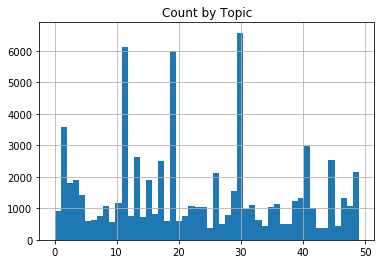

In [15]:
data['top_topic'].hist(bins=50)
plt.title('Count by Topic')
plt.show()

In [19]:
lda_50_45 = gensim.models.ldamodel.LdaModel.load('lda_50_45_model')

In [21]:
topics_to_csv(data, 50)

## Evaluate Categories

In [107]:
def eval_cat(df, num_topics, city):
    df_raw = pd.read_csv('/Users/alenastern/Google Drive File Stream/My Drive/Alena_Project/PR_Data/{}.csv'.format(city))
    
    df_raw_gp = df_raw.groupby('Dept').count()
    df_raw_gp['Summary'].plot(kind = 'bar')
    title = 'PRR Departments for {}'.format(city)
    plt.title(title)
    plt.show()
    
    df_city = df[df['city'] == city]
    df_merge = df_city.merge(df_raw, how ='left', on = 'Summary')
    df_merge['top_topic'] = pd.to_numeric(df_merge['top_topic'])
    for topic in range(0, num_topics):
        df_sub = df_merge[df_merge['top_topic'] == topic]
        df_gp = df_sub.groupby('Dept').count()
        df_gp['Summary'].plot(kind='bar')
        title = 'Departments for topic {} in {}'.format(topic, city)
        plt.title(title)
        plt.show()

In [89]:
city_list = ['Bainbridge', 'LasCruces', 'FortCollins', 'Mercer', 'Nola', 'Oakland', 'PaloAlto', 'Redmond', 
             'SanFrancisco', 'Vallejo']
fp = 'topics/lda_20_45_topics.csv'
df = pd.read_csv(fp)

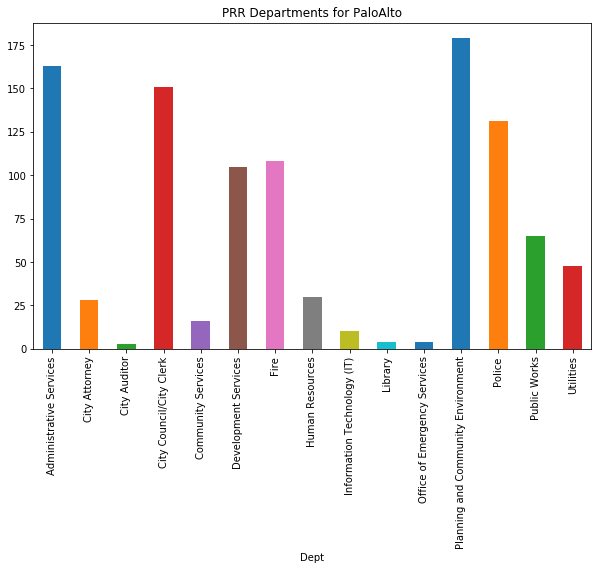

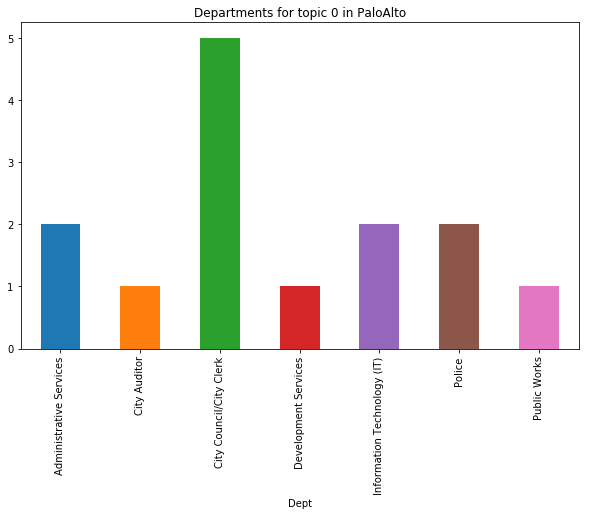

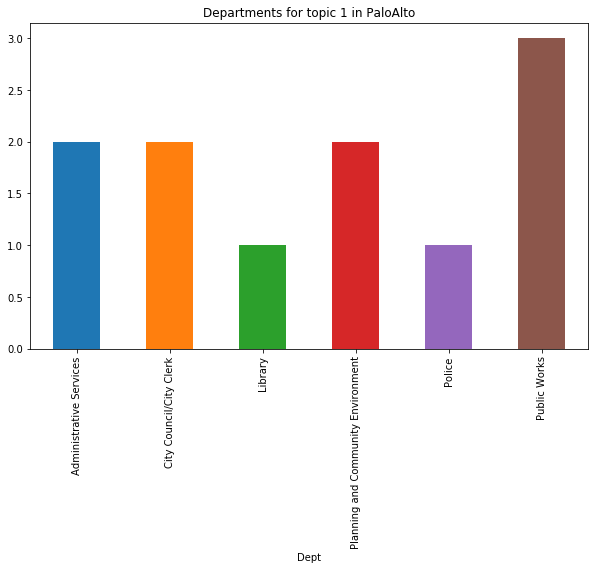

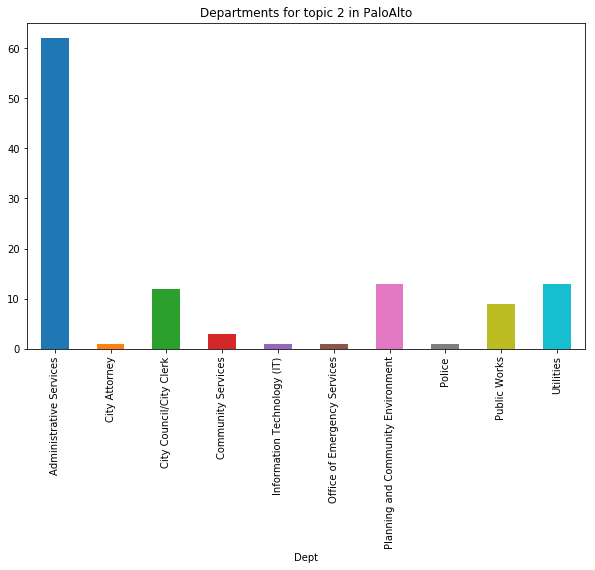

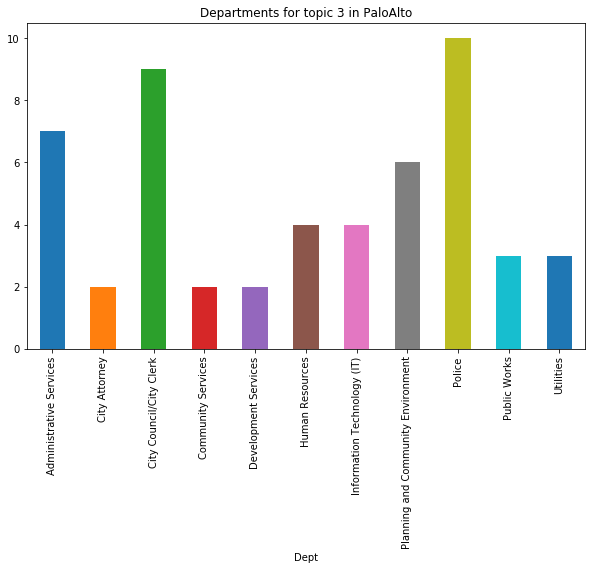

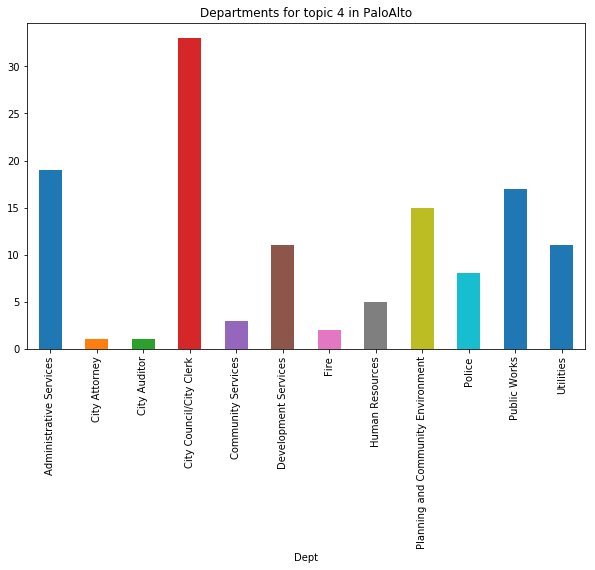

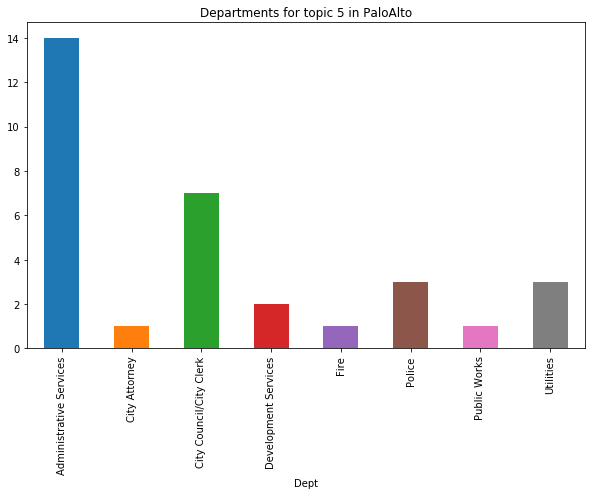

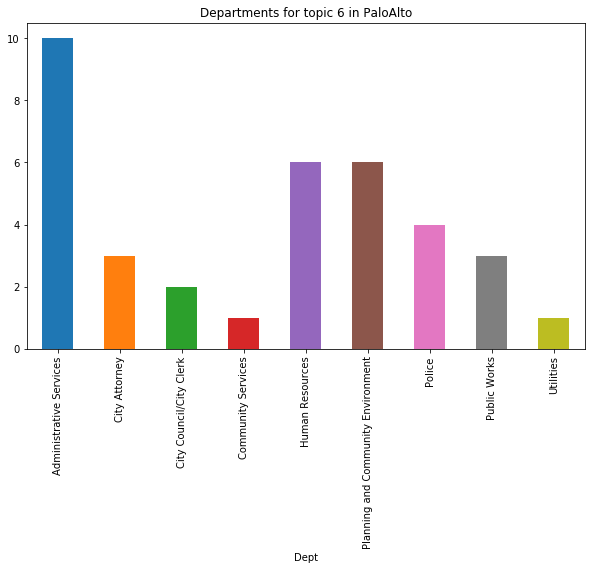

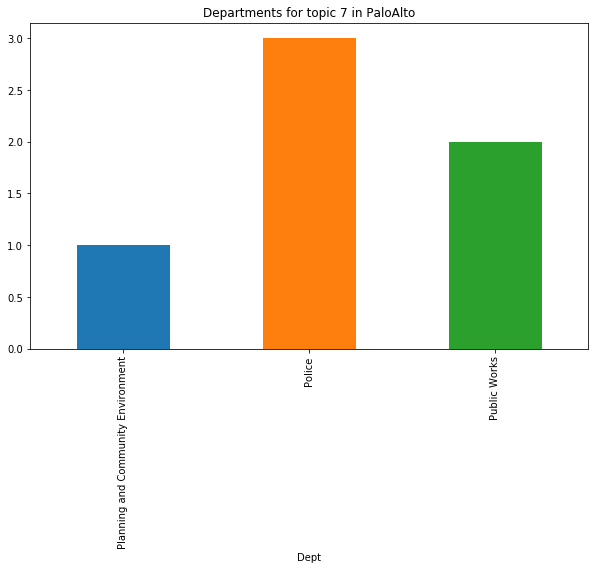

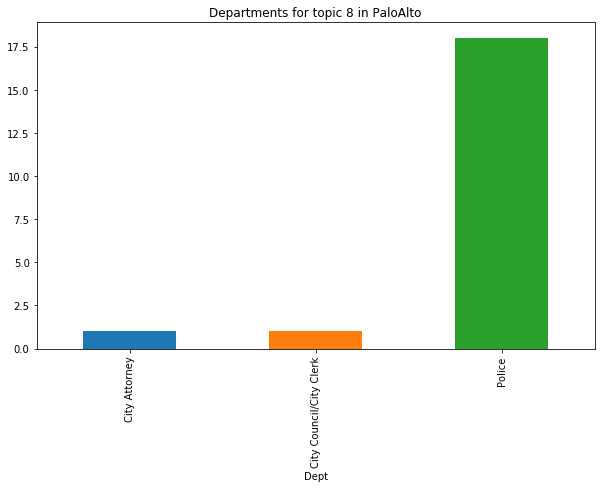

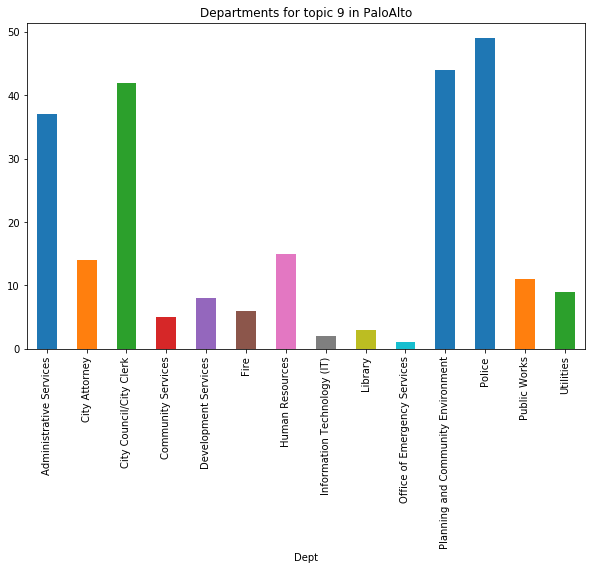

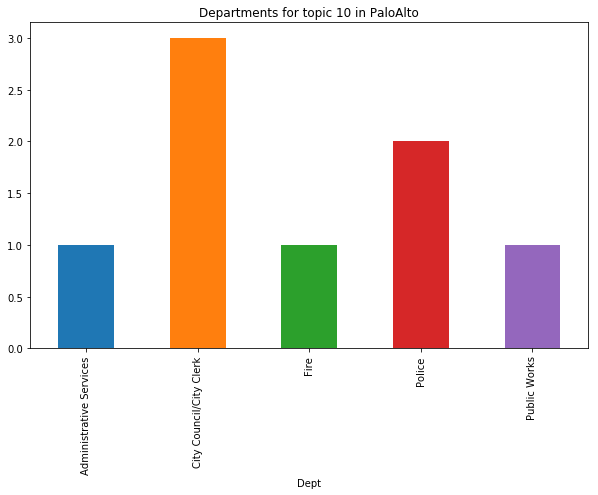

TypeError: Empty 'DataFrame': no numeric data to plot

In [115]:
eval_cat(df, 20, 'PaloAlto')

In [79]:
df_gp = df_sub.groupby('Dept').count()

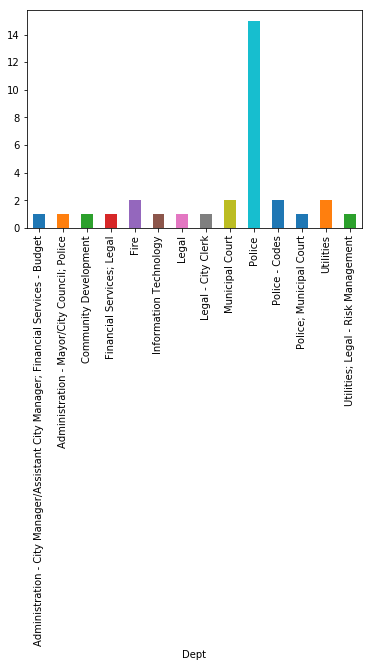

In [81]:
lda_20_45 = gensim.models.ldamodel.LdaModel.load('lda_20_45_model')

In [113]:
lda_20_45.show_topics(num_topics=20, formatted=False)

[(0,
  [('court', 0.036724545),
   ('anything', 0.020998748),
   ('domestic', 0.014498097),
   ('let', 0.013576341),
   ('charge', 0.013436156),
   ('try', 0.013304742),
   ('send', 0.012927327),
   ('criminal', 0.012513966),
   ('mr', 0.011974755),
   ('order', 0.011805346)]),
 (1,
  [('certified', 0.045605965),
   ('subcontractor', 0.027147388),
   ('tree', 0.025154732),
   ('card', 0.01778802),
   ('sign', 0.015327363),
   ('dept', 0.015299655),
   ('valley', 0.013364317),
   ('credit', 0.011572153),
   ('short', 0.011560791),
   ('many', 0.011459419)]),
 (2,
  [('project', 0.042869203),
   ('service', 0.041091476),
   ('contract', 0.026588412),
   ('bid', 0.024578642),
   ('license', 0.01906816),
   ('business', 0.015841715),
   ('program', 0.014876398),
   ('contractor', 0.014566953),
   ('construction', 0.014489511),
   ('submit', 0.012799689)]),
 (3,
  [('incident', 0.037551913),
   ('name', 0.031971008),
   ('year', 0.030913321),
   ('list', 0.030080773),
   ('incident_report',

### Load Best Model and Data

In [ ]:
final_model = gensim.models.ldamodel.LdaModel.load('___.csv')
final_df = pd.read_csv('topics/___.csv')

## Identify Most Popular Catgories

### "Winner take all" popularity metric:
* Scoring Rules:
    * Only the topic that composes the largest share of a document scores "points" for its "Adjusted Popularity" total.
    * If a topic composes the largest share of that document, its "points" are its composition score.


In [ ]:
# categorize data by final model identify highest topics
fp = 'topics/final_data.csv'
highest_topic(final_df, fp)

topic_gp = final_df.groupby('top_topic').sum()
topic_gp.reset_index(inplace = True)
topic_gp = topic_gp[['top_topic', 'topic_comp']]

 df = df.sort_values(by='Topic Number', ascending=True) 

    words_in_topics = [tup[1] for tup in lda_52_sixty.show_topics(num_topics=52, formatted=False)]
    df['Topic'] = words_in_topics

    df[["topic1", "topic2", "topic3", "topic4", 
           "topic5", "topic6", "topic7", "topic8", "topic9", "topic10"]] = df.Topic.apply(pd.Series)

topic_gp.sort_values(by=['topic_comp'], ascending = True)
topic_gp

## Topic Popularity over time

In [ ]:
def topic popularity(city):
    avg_month.plot(x='date_posted', y = ['total_price_excluding_optional_support', 'total_price_including_optional_support'], kind = 'line' )
    plt.show()